Download BTC data from [yahoo](https://finance.yahoo.com/quote/BTC-USD/history?period1=1546300800&period2=1657756800&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true)

In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

In [2]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english')) | {'rt'}

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/asemenov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
bitcoin_df = pd.read_csv('data/BTC-USD.csv')
bitcoin_df.Date = pd.to_datetime(bitcoin_df.Date)
bitcoin_df.set_index('Date', drop=True, inplace=True)
bitcoin_df['NextDayClose'] = bitcoin_df.Close.shift(-1)
# bitcoin_df = bitcoin_df.reindex(
#     pd.date_range(
#         '2019-01-01', 
#         bitcoin_df.index.max()
#     ),
#     method='backfill',
# )
bitcoin_df.head()

,Open,High,Low,Close,Adj Close,Volume,NextDayClose
Date,,,,,,,
2019-01-01,3746.713379,3850.913818,3707.231201,3843.520020,3843.520020,4324200990,3943.409424
2019-01-02,3849.216309,3947.981201,3817.409424,3943.409424,3943.409424,5244856836,3836.741211
2019-01-03,3931.048584,3935.685059,3826.222900,3836.741211,3836.741211,4530215219,3857.717529
2019-01-04,3832.040039,3865.934570,3783.853760,3857.717529,3857.717529,4847965467,3845.194580
2019-01-05,3851.973877,3904.903076,3836.900146,3845.194580,3845.194580,5137609824,4076.632568


In [4]:
bitcoin_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1291 entries, 2019-01-01 to 2022-07-14
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1291 non-null   float64
 1   High          1291 non-null   float64
 2   Low           1291 non-null   float64
 3   Close         1291 non-null   float64
 4   Adj Close     1291 non-null   float64
 5   Volume        1291 non-null   int64  
 6   NextDayClose  1290 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 80.7 KB


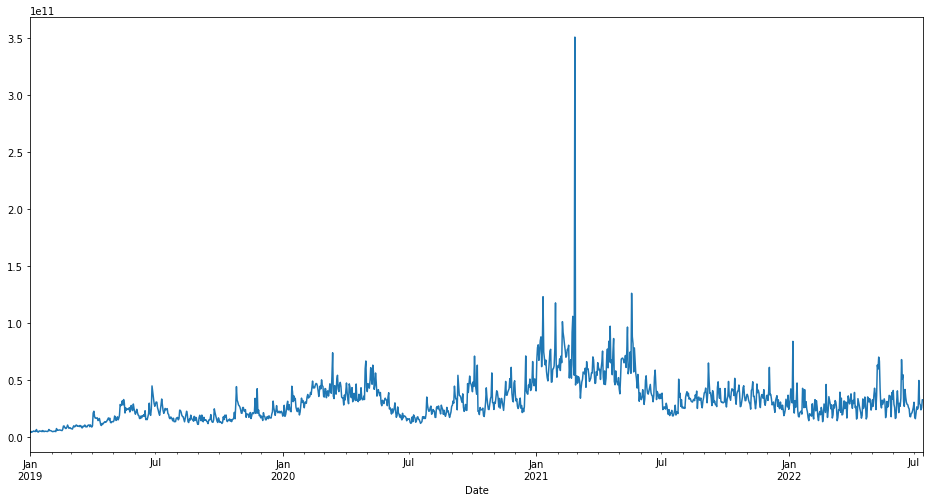

In [5]:
bitcoin_df.Volume.plot(figsize=(16, 8));

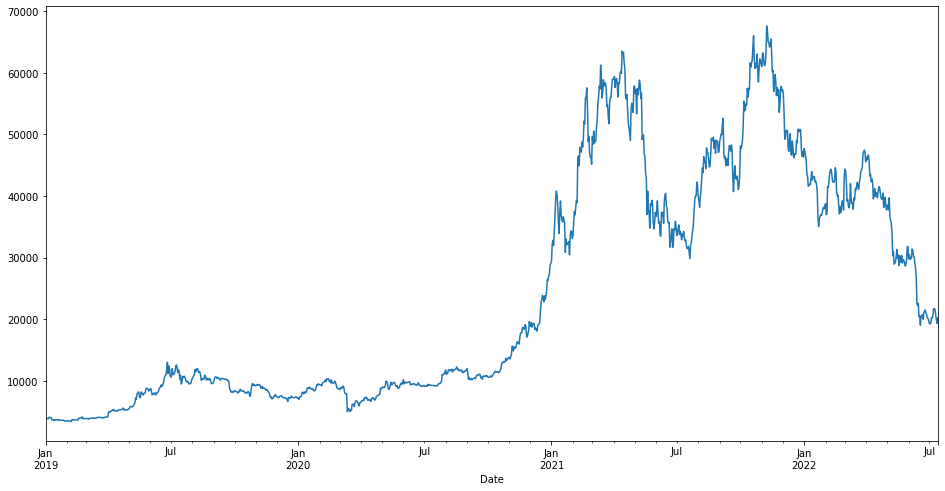

In [6]:
bitcoin_df.Close.plot(figsize=(16, 8));

In [7]:
elon_df = pd.concat([
    pd.read_csv('data/elon/2019.csv', index_col=0).set_index('id', drop=True),
    pd.read_csv('data/elon/2020.csv', index_col=0).set_index('id', drop=True),
    pd.read_csv('data/elon/2021.csv', index_col='id'),
])[['tweet', 'date']]
elon_df.rename(columns={'tweet': 'text'}, inplace=True)
elon_df['datetime'] = pd.to_datetime(elon_df['date'])
elon_df['date'] = pd.to_datetime(elon_df['datetime'].dt.date)
elon_df = elon_df.query("date >= '2019-01-01' and date < '2022-01-01'")
elon_df.drop_duplicates(inplace=True)
elon_df.head()

,text,date,datetime
id,,,
1211071324518531072,@Joe__Wakefield @austinbarnard45 @tjq1190 @tyg...,2019-12-28,2019-12-28 23:47:59
1211069054779301894,@austinbarnard45 @tjq1190 @tyger_cyber @fawful...,2019-12-28,2019-12-28 23:38:57
1211064937004589056,@IrinaAntony @tjq1190 @tyger_cyber @fawfulfan ...,2019-12-28,2019-12-28 23:22:36
1211054942192119808,@tjq1190 @tyger_cyber @fawfulfan @_Mikemo He d...,2019-12-28,2019-12-28 22:42:53
1211051740562366464,@geofficient Pretty much,2019-12-28,2019-12-28 22:30:09


In [8]:
elon_df = elon_df[elon_df.text.str.lower().str.contains('bitcoin')]

In [9]:
def text_preprocessor(v: str) -> str:
    v = v.lower()
    v = re.sub(r'@[^\s]+', '', v)
    v = re.sub(r'https?://[^\s]+', '', v)
    v = re.sub(r'&\w+;', '', v)
    v = re.sub('\W+', ' ', v)
    v = v.strip()
    return v

In [10]:
empty_tweets = (
    elon_df.text
    .apply(text_preprocessor)
    .apply(lambda v: ' '.join(word for word in v.split() if word not in stop_words))
    .apply(lambda v: not not re.fullmatch('\W*', v))
)
print(elon_df[empty_tweets].shape)
elon_df[empty_tweets]

(2, 3)


,text,date,datetime
id,,,
1256351293007736832,@Bitcoin 🤣🤣,2020-05-01,2020-05-01 22:34:24
1215528293266362368,@bitcoin2020conf 😉,2020-01-10,2020-01-10 06:58:23


In [11]:
elon_df = elon_df[~empty_tweets]
elon_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33 entries, 1340588909974200321 to 1362598034866118658
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   text      33 non-null     object        
 1   date      33 non-null     datetime64[ns]
 2   datetime  33 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(1)
memory usage: 1.0+ KB


In [12]:
elon_df['bitcoin_grow_in_this_day'] = elon_df.apply(
    lambda r: bitcoin_df.loc[r['date']], 
    axis=1
).apply(
    lambda r: np.int32(r.NextDayClose > r.Open), 
    axis=1
)

In [13]:
elon_df['bitcoin_grow_in_this_day'].mean()

0.42424242424242425

In [14]:
elon_df.head()

,text,date,datetime,bitcoin_grow_in_this_day
id,,,,
1340588909974200321,Bitcoin is almost as bs as fiat money,2020-12-20,2020-12-20 09:24:37,0
1340573003579617280,Bitcoin is my safe word,2020-12-20,2020-12-20 08:21:25,0
1328458535340949505,@Maisie_Williams 🎶 Toss a bitcoin to ur Witcher 🎶,2020-11-16,2020-11-16 22:02:51,1
1261429085999296512,@jk_rowling I still only own 0.25 Bitcoins btw,2020-05-15,2020-05-15 22:51:44,0
1261416824459030529,"@jk_rowling Pretty much, although massive curr...",2020-05-15,2020-05-15 22:03:01,0


In [15]:
tfidf_vectorizer = TfidfVectorizer(
    stop_words=stop_words,
    ngram_range=(1, 2),
    max_features=2000,
    preprocessor=text_preprocessor
)

In [16]:
X = tfidf_vectorizer.fit_transform(elon_df.text).toarray()
y = elon_df.bitcoin_grow_in_this_day

In [17]:
train_percent = 0.9
idx = int(train_percent * len(y))

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=0.9, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((29, 486), (4, 486), (29,), (4,))

In [18]:
rnd = np.random.default_rng(42)

y_baseline = np.int32(rnd.random(y_test.shape) <= y.mean())
print('Test classification report (baseline):\n')
print(classification_report(y_true=y_test, y_pred=y_baseline))

Test classification report (baseline):

              precision    recall  f1-score   support

           0       0.50      1.00      0.67         2
           1       0.00      0.00      0.00         2

    accuracy                           0.50         4
   macro avg       0.25      0.50      0.33         4
weighted avg       0.25      0.50      0.33         4



/home/asemenov/study/otus/MLProfessional/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/asemenov/study/otus/MLProfessional/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/asemenov/study/otus/MLProfessional/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

In [19]:
%%time
lin_regr = LogisticRegressionCV(
    max_iter=5000,
    random_state=42,
    scoring='accuracy',
).fit(X_train, y_train)

CPU times: user 1.14 s, sys: 1.31 s, total: 2.45 s
Wall time: 340 ms


In [20]:
y_train_pred = lin_regr.predict(X_train)
print('Train classification report:\n')
print(classification_report(y_true=y_train, y_pred=y_train_pred))

Train classification report:

              precision    recall  f1-score   support

           0       0.59      1.00      0.74        17
           1       0.00      0.00      0.00        12

    accuracy                           0.59        29
   macro avg       0.29      0.50      0.37        29
weighted avg       0.34      0.59      0.43        29



/home/asemenov/study/otus/MLProfessional/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/asemenov/study/otus/MLProfessional/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/asemenov/study/otus/MLProfessional/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

In [21]:
y_pred = lin_regr.predict(X_test)
print('Test classification report:\n')
print(classification_report(y_true=y_test, y_pred=y_pred))

Test classification report:

              precision    recall  f1-score   support

           0       0.50      1.00      0.67         2
           1       0.00      0.00      0.00         2

    accuracy                           0.50         4
   macro avg       0.25      0.50      0.33         4
weighted avg       0.25      0.50      0.33         4



/home/asemenov/study/otus/MLProfessional/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/asemenov/study/otus/MLProfessional/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/asemenov/study/otus/MLProfessional/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

In [22]:
words_coeffs = pd.Series(dict(zip(
    tfidf_vectorizer.get_feature_names_out(), 
    lin_regr.coef_.flatten()
)))

In [23]:
words_coeffs.sort_values(ascending=False).head(15)

bitcoin close    0.000030
close            0.000030
cancer           0.000029
cures            0.000029
bitcoin cures    0.000029
cures cancer     0.000029
tesla            0.000028
tesla bitcoin    0.000026
miners           0.000024
ur witcher       0.000024
toss bitcoin     0.000024
bitcoin ur       0.000024
witcher          0.000024
toss             0.000024
ur               0.000024
dtype: float64

In [24]:
words_coeffs.sort_values(ascending=True).head(15)

ton             -0.000024
sure ton        -0.000024
sure            -0.000024
based data      -0.000024
based           -0.000024
data            -0.000024
buy tesla       -0.000023
buy             -0.000023
pretty          -0.000022
pretty much     -0.000022
much            -0.000020
bitcoin         -0.000017
right bitcoin   -0.000017
bitcoin haha    -0.000017
oh right        -0.000017
dtype: float64

In [25]:
random_forest = RandomForestClassifier(random_state=42).fit(X_train, y_train)

In [26]:
y_train_pred = random_forest.predict(X_train)
print('Train classification report:\n')
print(classification_report(y_true=y_train, y_pred=y_train_pred))

Train classification report:

              precision    recall  f1-score   support

           0       0.94      1.00      0.97        17
           1       1.00      0.92      0.96        12

    accuracy                           0.97        29
   macro avg       0.97      0.96      0.96        29
weighted avg       0.97      0.97      0.97        29



In [27]:
y_pred = random_forest.predict(X_test)
print('Test classification report:\n')
print(classification_report(y_true=y_test, y_pred=y_pred))

Test classification report:

              precision    recall  f1-score   support

           0       0.50      1.00      0.67         2
           1       0.00      0.00      0.00         2

    accuracy                           0.50         4
   macro avg       0.25      0.50      0.33         4
weighted avg       0.25      0.50      0.33         4



/home/asemenov/study/otus/MLProfessional/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/asemenov/study/otus/MLProfessional/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/asemenov/study/otus/MLProfessional/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

In [28]:
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [29]:
%%time
CV_rfc = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=5,
    n_jobs=-1,
    verbose=1,
    scoring='accuracy',
)
CV_rfc.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
CPU times: user 610 ms, sys: 99.6 ms, total: 709 ms
Wall time: 20.5 s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [200, 500]},
             scoring='accuracy', verbose=1)

In [30]:
y_train_pred = CV_rfc.predict(X_train)
print('Train classification report:\n')
print(classification_report(y_true=y_train, y_pred=y_train_pred))

Train classification report:

              precision    recall  f1-score   support

           0       0.77      1.00      0.87        17
           1       1.00      0.58      0.74        12

    accuracy                           0.83        29
   macro avg       0.89      0.79      0.80        29
weighted avg       0.87      0.83      0.82        29



In [31]:
y_pred = CV_rfc.predict(X_test)
print('Test classification report:\n')
print(classification_report(y_true=y_test, y_pred=y_pred))

Test classification report:

              precision    recall  f1-score   support

           0       0.50      1.00      0.67         2
           1       0.00      0.00      0.00         2

    accuracy                           0.50         4
   macro avg       0.25      0.50      0.33         4
weighted avg       0.25      0.50      0.33         4



/home/asemenov/study/otus/MLProfessional/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/asemenov/study/otus/MLProfessional/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/asemenov/study/otus/MLProfessional/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

In [32]:
words_importances = pd.Series(dict(zip(
    tfidf_vectorizer.get_feature_names_out(), 
    CV_rfc.best_estimator_.feature_importances_
)))

In [33]:
words_importances.sort_values(ascending=False).head(15)

bitcoin           0.035106
tesla bitcoin     0.017519
liquidity         0.017361
tesla             0.017030
toss              0.015767
many bitcoin      0.015696
holdings          0.014699
sold 10           0.014089
10                0.011577
north             0.011508
usage             0.010577
ur                0.010562
ask miners        0.010384
cures cancer      0.010030
bitcoin miners    0.009775
dtype: float64

In [34]:
words_importances.sort_values(ascending=True).head(15)

inaccurate            0.0
handful               0.0
handful big           0.0
hash rate             0.0
hash strings          0.0
hashers               0.0
hashing               0.0
hashing aka           0.0
hashing companies     0.0
high thighs           0.0
highly                0.0
highly centralized    0.0
impossible small      0.0
improve               0.0
xinjiang flooded      0.0
dtype: float64

In [35]:
elon_df[elon_df.text.str.lower().str.contains('bitcoin')].date

id
1340588909974200321   2020-12-20
1340573003579617280   2020-12-20
1328458535340949505   2020-11-16
1261429085999296512   2020-05-15
1261416824459030529   2020-05-15
1256353943765921792   2020-05-01
1215526980449255424   2020-01-10
1461942451053252612   2021-11-20
1452334458066149377   2021-10-24
1452332044743323654   2021-10-24
1420529868404518913   2021-07-29
1417207016519454724   2021-07-19
1417204066552205332   2021-07-19
1408246534093918210   2021-06-25
1408246196603346947   2021-06-25
1408244494567456769   2021-06-25
1405482221666852871   2021-06-17
1404132183254523905   2021-06-13
1401091921746006017   2021-06-05
1400620080090730501   2021-06-04
1396914548167233537   2021-05-24
1395472799020421120   2021-05-21
1394170030741413888   2021-05-17
1393993975019749382   2021-05-16
1393991411524120576   2021-05-16
1392602041025843203   2021-05-13
1386821144037236737   2021-04-27
1374619672973221892   2021-03-24
1374619379929772034   2021-03-24
1374617643446063105   2021-03-24
1370449

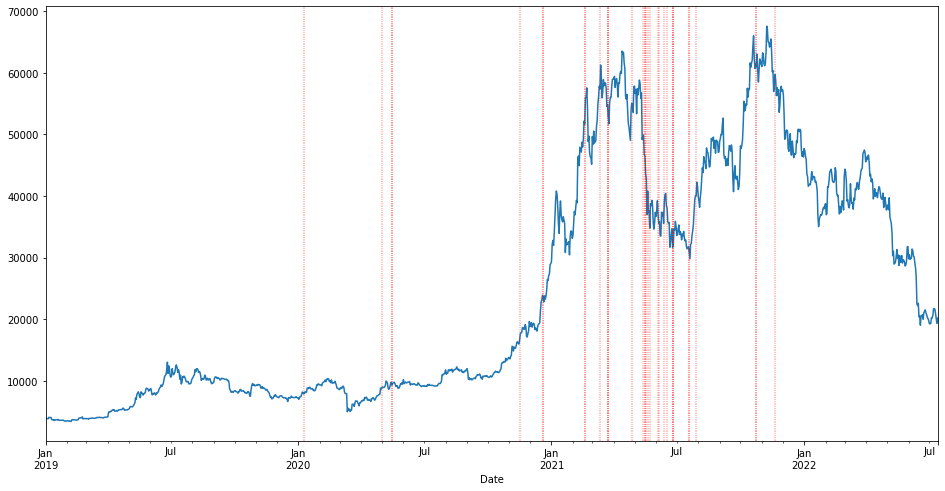

In [36]:
bitcoin_df.Close.plot(figsize=(16, 8));
for xc in elon_df[elon_df.text.str.lower().str.contains('bitcoin')].date:
    plt.axvline(x=xc, color='red', dashes=(0.2, 1))